In [1]:
import pandas as pd

df = pd.read_csv("/content/tweets.csv")
df.head()

,tweets,labels
0,Obama has called the GOP budget social Darwini...,1
1,"In his teen years, Obama has been known to use...",0
2,IPA Congratulates President Barack Obama for L...,0
3,RT @Professor_Why: #WhatsRomneyHiding - his co...,0
4,RT @wardollarshome: Obama has approved more ta...,1


In [2]:
df.shape

(1364, 2)

In [3]:
df.labels.value_counts()

0    931
1    352
2     81
Name: labels, dtype: int64

In [4]:
df['tweets_clean'] = df['tweets'].str.replace('RT',"").str.strip().str.replace(":","")

In [5]:
import random
import torch, torchtext
from torchtext import data
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
# Manual Seed
SEED = 43
torch.manual_seed(SEED)

In [7]:
Tweet = torchtext.legacy.data.Field(sequential = True, tokenize = 'spacy', batch_first =True, include_lengths=True)
Label = torchtext.legacy.data.LabelField(tokenize ='spacy', is_target=True, batch_first =True, sequential =False)

In [8]:
fields = [('tweet', Tweet), ('label', Label)]

In [9]:
example = [torchtext.legacy.data.Example.fromlist([df.tweets_clean[i],df.labels[i]], fields) for i in range(df.shape[0])] 

In [10]:
twitterDataset = torchtext.legacy.data.Dataset(example, fields)

In [11]:
(train, valid) = twitterDataset.split(split_ratio=[85, 15], random_state = random.seed(SEED))

In [12]:
len(train), len(valid)

(1159, 205)

In [13]:
vars(train.examples[11])

{'label': 1,
 'tweet': ['@sweetbay',
  'That',
  'was',
  'Paul',
  'Ryan',
  "'s",
  'budget',
  '.',
  'How',
  'did',
  'Obama',
  "'s",
  'budget',
  'do',
  '?',
  'Getting',
  'educated',
  'on',
  'the',
  'facts',
  'is',
  'the',
  'first',
  'step',
  'in',
  'losing',
  'that',
  'liberalism',
  '!']}

In [14]:
Tweet.build_vocab(train)
Label.build_vocab(train)

In [15]:
print('Size of input vocab : ', len(Tweet.vocab))
print('Size of label vocab : ', len(Label.vocab))
print('Top 10 words appreared repeatedly :', list(Tweet.vocab.freqs.most_common(10)))
print('Labels : ', Label.vocab.stoi)

Size of input vocab :  4640
Size of label vocab :  3
Top 10 words appreared repeatedly : [('Obama', 1069), ('#', 780), ('.', 760), (',', 598), ('"', 550), ('the', 542), ('?', 420), ('to', 400), ('/', 371), ('http//t.co', 352)]
Labels :  defaultdict(None, {0: 0, 1: 1, 2: 2})


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [17]:
train_iterator, valid_iterator = torchtext.legacy.data.BucketIterator.splits((train, valid), batch_size = 1, 
                                                            sort_key = lambda x: len(x.tweet),
                                                            sort_within_batch=True, device = device)

In [18]:
next(iter(train_iterator))
#len(train.examples[11].tweet)


[torchtext.legacy.data.batch.Batch of size 1]
	[.tweet]:('[torch.cuda.LongTensor of size 1x27 (GPU 0)]', '[torch.cuda.LongTensor of size 1 (GPU 0)]')
	[.label]:[torch.cuda.LongTensor of size 1 (GPU 0)]

In [19]:
import os, pickle
with open('tokenizer.pkl', 'wb') as tokens: 
    pickle.dump(Tweet.vocab.stoi, tokens)

In [20]:
import torch.nn as nn
import torch.nn.functional as F


class Encoder(nn.Module):
  def __init__(self, input_size, hidden_size):
    super().__init__()
    self.encoder = nn.LSTMCell(input_size, hidden_size, bias=False)
  def forward(self, x, mask, lengths, visualize=False):
      hidden_state, cell_state = mask
      for idx in range(lengths[0]):
        hidden_state, cell_state = self.encoder(x[0][idx].unsqueeze(0), (hidden_state, cell_state))
        if visualize:
          sns.heatmap(hidden_state[0].detach().numpy().reshape(-1, 4), fmt=".2f", vmin=-1, vmax=1, annot=True, cmap="YlGnBu").set(title=f"Encoder Hidden State, step={idx}")
          plt.show()
      return hidden_state, cell_state

class Decoder(nn.Module):
  def __init__(self, emb_size, hidden_size):
    super().__init__()
    self.decoder = nn.LSTMCell(emb_size, hidden_size, bias=False)
  def forward(self, prev_embeded, encoder_hidden, visualize=False):
    hidden_state, cell = encoder_hidden
    max_steps = 3
    for idx in range(max_steps):
      hidden_state, cell = self.decoder(prev_embeded, (hidden_state, cell))
      if visualize:
        sns.heatmap(hidden_state[0].detach().numpy().reshape(-1, 4), fmt=".2f", vmin=-1, vmax=1, annot=True, cmap="YlGnBu").set(title=f"Decoder Hidden State, step={idx}")
        plt.show()
    return hidden_state, cell

class classifier(nn.Module):
    
    # Define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_classes):
        
        super().__init__()          
        
        self.num_hidden_nodes = hidden_dim

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM layer
        self.encoder = Encoder(embedding_dim, hidden_dim)
        # try using nn.GRU or nn.RNN here and compare their performances
        # try bidirectional and compare their performances
        
        # Dense layer
        self.fc_encoder = nn.Linear(hidden_dim, output_dim, bias=False)

        self.decoder = Decoder(output_dim, hidden_dim)

        self.fc_decoder = nn.Linear(hidden_dim, output_dim, bias=False)

        self.fc_final = nn.Linear(output_dim, n_classes, bias=False)
        
    def forward(self, text, text_lengths, visualize=False):

        # text = [batch size, sent_length]
        embedded = self.embedding(text)
        # embedded = [batch size, sent_len, emb dim]

        inital_hidden = torch.randn(len(text), self.num_hidden_nodes,device=self.device)
        # (batch, hidden_size)
        inital_cell = torch.randn(len(text), self.num_hidden_nodes,device=self.device)
        
        hidden, cell = self.encoder(embedded, (inital_hidden, inital_cell), text_lengths, visualize)

        encoder_single_vector = self.fc_encoder(hidden)
        if visualize:
          sns.heatmap(encoder_single_vector[0].detach().numpy().reshape(-1, 1), fmt=".2f", vmin=-1, vmax=1, annot=True, cmap="YlGnBu").set(title=f"Encoder Single Vector")
          plt.show()
        # Hidden = [batch size, hid dim * num directions]
        hidden, cell = self.decoder(encoder_single_vector, (hidden, cell),visualize)  
        decoder_single_vector = self.fc_decoder(hidden)

        if visualize:
            sns.heatmap(decoder_single_vector[0].detach().numpy().reshape(-1, 1), fmt=".2f", vmin=-1, vmax=1, annot=True, cmap="YlGnBu").set(title=f"Decoder Single Vector")
            plt.show()
        # Final activation function softmax
        output = self.fc_final(decoder_single_vector)
        if visualize:
            sns.heatmap(output[0].detach().numpy().reshape(-1, 1), fmt=".2f", vmin=-1, vmax=1, annot=True, cmap="YlGnBu").set(title=f"Final Output")
            plt.show()
        output = F.softmax(output, dim=1)         
        return output

In [21]:
# Define hyperparameters
size_of_vocab = len(Tweet.vocab)
embedding_dim = 100
num_hidden_nodes = 24
output_nodes = 16
num_classes = 3
# dropout = 0.2

# Instantiate the model
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes, output_nodes, num_classes)
model.device=device

In [22]:
print(model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

classifier(
  (embedding): Embedding(4640, 100)
  (encoder): Encoder(
    (encoder): LSTMCell(100, 24, bias=False)
  )
  (fc_encoder): Linear(in_features=24, out_features=16, bias=False)
  (decoder): Decoder(
    (decoder): LSTMCell(16, 24, bias=False)
  )
  (fc_decoder): Linear(in_features=24, out_features=16, bias=False)
  (fc_final): Linear(in_features=16, out_features=3, bias=False)
)
The model has 480,560 trainable parameters


In [23]:
import torch.optim as optim

# define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.CrossEntropyLoss()

# define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    _, predictions = torch.max(preds, 1)
    
    correct = (predictions == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
# push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

In [24]:
def train(model, iterator, optimizer, criterion):
    
    # initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0

    # set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        # resets the gradients after every batch
        optimizer.zero_grad()   
        
        # retrieve text and no. of words
        tweet, tweet_lengths = batch.tweet  
        
        # convert to 1D tensor
        predictions = model(tweet, tweet_lengths) #.squeeze()  
        
        # compute the loss
        loss = criterion(predictions, batch.label)        
        
        # compute the binary accuracy
        acc = binary_accuracy(predictions, batch.label)   
        
        # backpropage the loss and compute the gradients
        loss.backward()       
        
        # update the weights
        optimizer.step()      
        
        # loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [25]:
def evaluate(model, iterator, criterion):
    
    # initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    # deactivating dropout layers
    model.eval()
    
    # deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            # retrieve text and no. of words
            tweet, tweet_lengths = batch.tweet
            
            # convert to 1d tensor
            predictions = model(tweet, tweet_lengths) #.squeeze()
            
            # compute loss and accuracy
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)
            
            # keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [26]:
N_EPOCHS = 10
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
     
    # train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    
    # evaluate the model
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% \n')

	Train Loss: 0.957 | Train Acc: 61.95%
	 Val. Loss: 0.893 |  Val. Acc: 65.37% 

	Train Loss: 0.846 | Train Acc: 69.11%
	 Val. Loss: 0.874 |  Val. Acc: 64.88% 

	Train Loss: 0.813 | Train Acc: 72.22%
	 Val. Loss: 0.861 |  Val. Acc: 71.71% 

	Train Loss: 0.777 | Train Acc: 79.47%
	 Val. Loss: 0.829 |  Val. Acc: 72.68% 

	Train Loss: 0.733 | Train Acc: 81.71%
	 Val. Loss: 0.815 |  Val. Acc: 72.68% 

	Train Loss: 0.716 | Train Acc: 83.69%
	 Val. Loss: 0.808 |  Val. Acc: 73.66% 

	Train Loss: 0.708 | Train Acc: 84.81%
	 Val. Loss: 0.801 |  Val. Acc: 73.66% 

	Train Loss: 0.701 | Train Acc: 85.33%
	 Val. Loss: 0.798 |  Val. Acc: 75.61% 

	Train Loss: 0.696 | Train Acc: 85.50%
	 Val. Loss: 0.814 |  Val. Acc: 71.71% 

	Train Loss: 0.688 | Train Acc: 86.37%
	 Val. Loss: 0.800 |  Val. Acc: 75.61% 



In [34]:
#load weights and tokenizer
device='cpu'
path='./saved_weights.pt'
model.load_state_dict(torch.load(path));
model.device=device
model = model.to(device)
model.eval();
tokenizer_file = open('./tokenizer.pkl', 'rb')
tokenizer = pickle.load(tokenizer_file)
categories = {0: "Negative", 1:"Positive", 2:"Neutral"}
#inference 

import spacy
nlp = spacy.load('en')

def classify_tweet(tweet,visualize=False):
    
    categories = {0: "Negative", 1:"Positive", 2:"Neutral"}
    
    # tokenize the tweet 
    tokenized = [tok.text for tok in nlp.tokenizer(tweet)] 
    # convert to integer sequence using predefined tokenizer dictionary
    indexed = [tokenizer[t] for t in tokenized]        
    # compute no. of words        
    length = [len(indexed)]
    # convert to tensor                                    
    tensor = torch.LongTensor(indexed).to(device)   
    # reshape in form of batch, no. of words           
    tensor = tensor.unsqueeze(1).T  
    # convert to tensor                          
    length_tensor = torch.LongTensor(length)
    # Get the model prediction                  
    prediction = model(tensor, length_tensor, visualize=visualize)

    _, pred = torch.max(prediction, 1) 
    
    return categories[pred.item()]

## Correctly Classified States



Input:- Obama has called the GOP budget social Darwinism. Nice try, but they believe in social creationism.


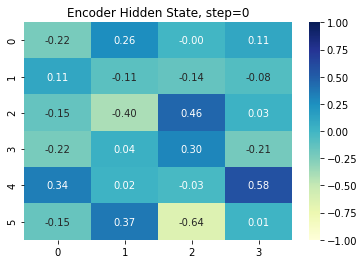

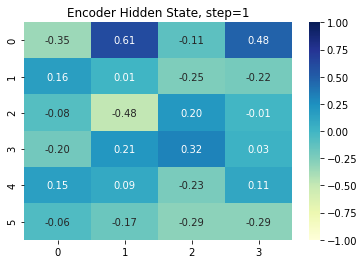

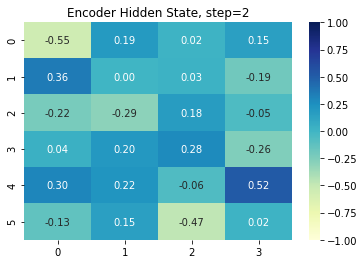

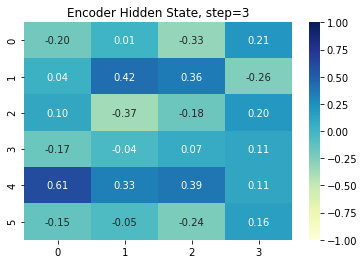

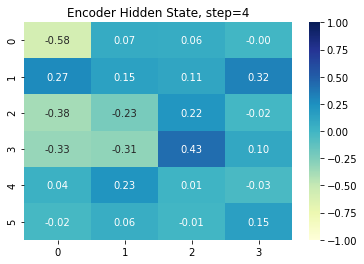

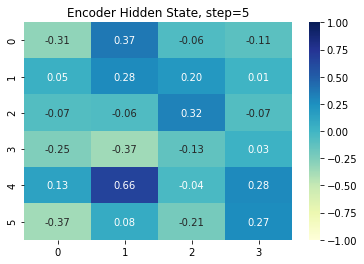

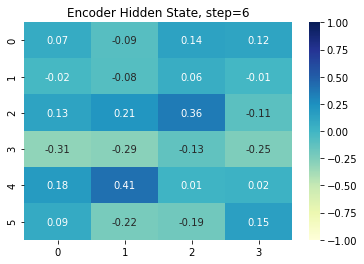

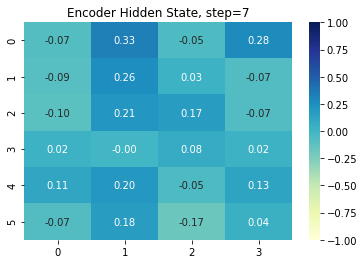

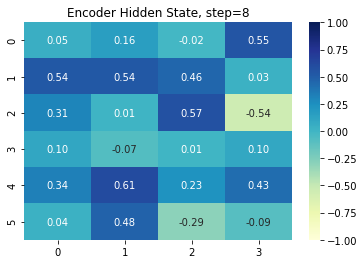

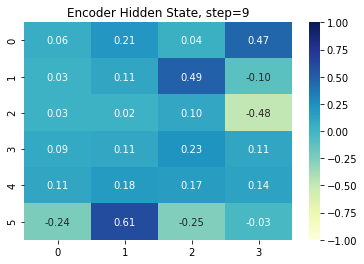

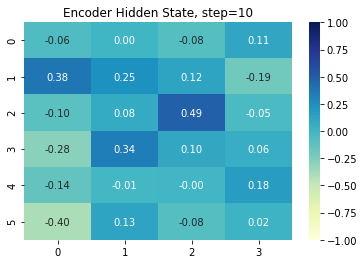

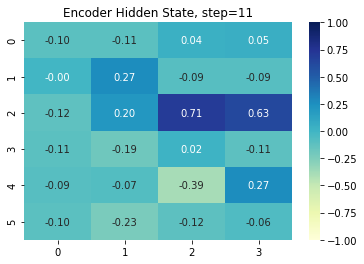

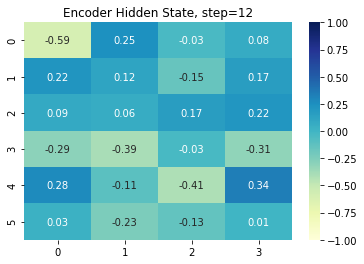

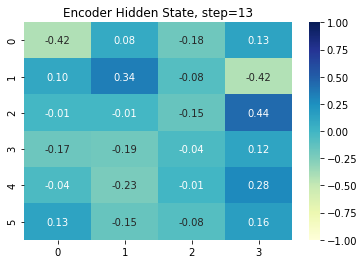

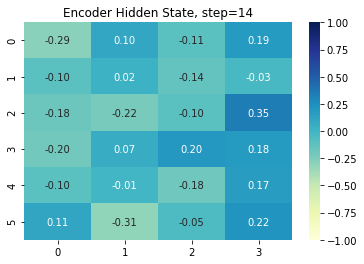

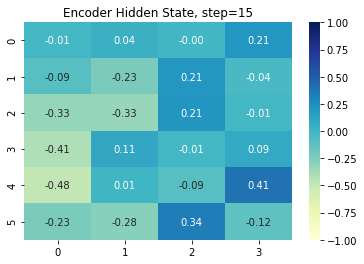

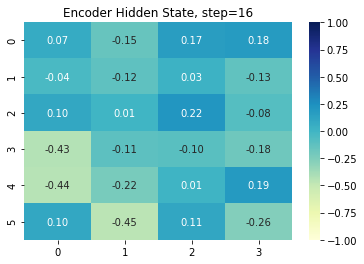

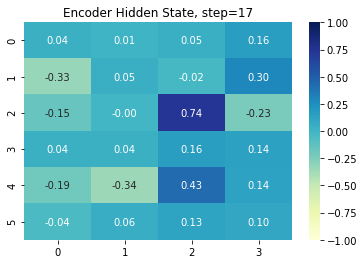

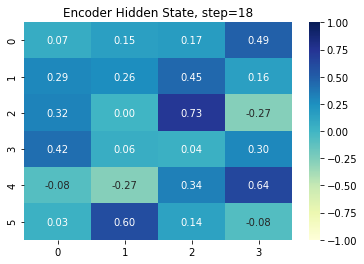

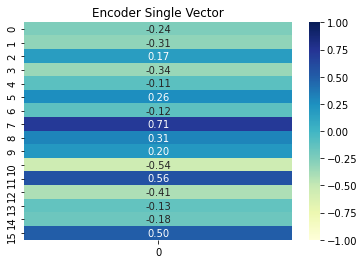

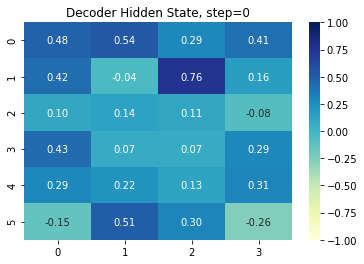

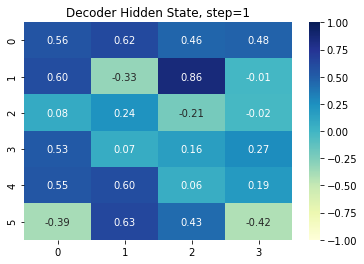

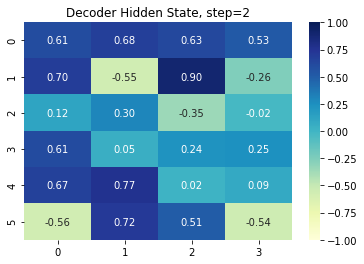

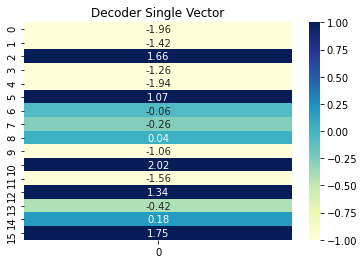

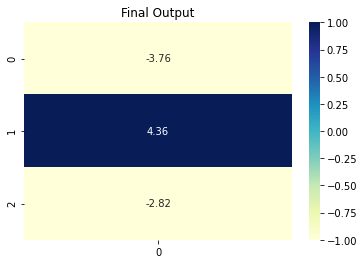

Predicted Label:-  Positive
Actual Label:-  Positive


In [49]:
print('\n\nInput:-', df.at[0,'tweets_clean'])
print('Predicted Label:- ',classify_tweet(df.at[0,'tweets_clean'], visualize=True))
print('Actual Label:- ' ,categories[df.at[0,'labels']])

In [40]:
df['Predicted'] = df['tweets_clean'].apply(classify_tweet)

## Correctly Classified

In [46]:
df['label_names'] = df['labels'].map(categories)
Correct_df = df[df['label_names']==df['Predicted']].copy().reset_index(drop=True)
for i in range(10):
  print('\n\nInput:-', Correct_df.at[i,'tweets_clean'])
  print('Predicted Label:- ', Correct_df.at[i,'Predicted'])
  print('Actual Label:- ' , Correct_df.at[i,'label_names'])



Input:- Obama has called the GOP budget social Darwinism. Nice try, but they believe in social creationism.
Predicted Label:-  Positive
Actual Label:-  Positive


Input:- In his teen years, Obama has been known to use marijuana and cocaine.
Predicted Label:-  Negative
Actual Label:-  Negative


Input:- IPA Congratulates President Barack Obama for Leadership Regarding JOBS Act WASHINGTON, Apr 05, 2012 (BUSINESS W... http//t.co/8le3DC8E
Predicted Label:-  Negative
Actual Label:-  Negative


Input:- @Professor_Why #WhatsRomneyHiding - his connection to supporters of Critical Race Theory.... Oh wait, that was Obama, not Romney...
Predicted Label:-  Negative
Actual Label:-  Negative


Input:- @wardollarshome Obama has approved more targeted assassinations than any modern US prez; READ &  http//t.co/bfC4gbBW
Predicted Label:-  Positive
Actual Label:-  Positive


Input:- Video shows federal officials joking about cost of lavish conference http//t.co/2i4SmoPM #obama #crime #p2 #news #tcot #t

## Miss-classified

In [47]:
Incorrect_df = df[df['label_names']!=df['Predicted']].copy().reset_index(drop=True)
for i in range(10):
  print('\n\nInput:-', Incorrect_df.at[i,'tweets_clean'])
  print('Predicted Label:- ', Incorrect_df.at[i,'Predicted'])
  print('Actual Label:- ' , Incorrect_df.at[i,'label_names'])



Input:- one Chicago kid who says "Obama is my man" tells Jesse Watters that the gun violence in Chicago is like "World War 17"
Predicted Label:-  Neutral
Actual Label:-  Negative


Input:- A valid explanation for why Obama won't let women on the golf course.   #WhatsRomneyHiding
Predicted Label:-  Negative
Actual Label:-  Positive


Input:- #WhatsRomneyHiding? Obama's dignity and sense of humor? #p2 #tcot
Predicted Label:-  Negative
Actual Label:-  Neutral


Input:- RealClearPolitics - Obama's Organizational Advantage on Full ... As a small but electorally significant state t... http//t.co/3Ax22aBB
Predicted Label:-  Negative
Actual Label:-  Neutral


Input:- @wilycyotee Pres. Obama's ongoing support of women is another reason I am so proud he is my President!  @edshow #Obama2012
Predicted Label:-  Negative
Actual Label:-  Neutral


Input:- If Obama win 2012 Election wait til 2016 he will have full white hair! just like Bill clinton!
Predicted Label:-  Negative
Actual Label:-  Neutra

## Mis-Classified States



Input:- one Chicago kid who says "Obama is my man" tells Jesse Watters that the gun violence in Chicago is like "World War 17"


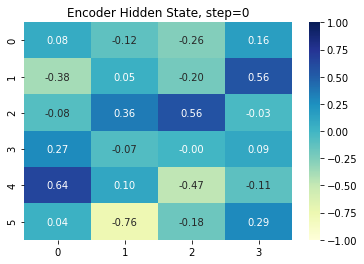

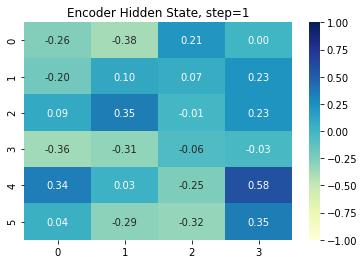

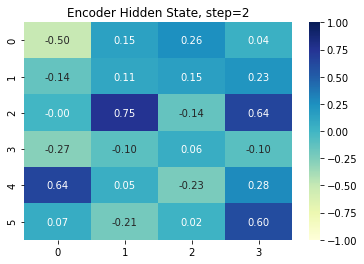

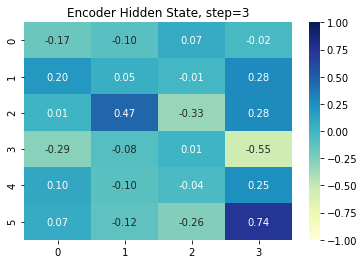

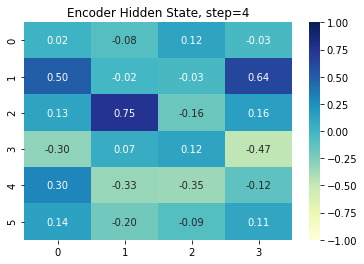

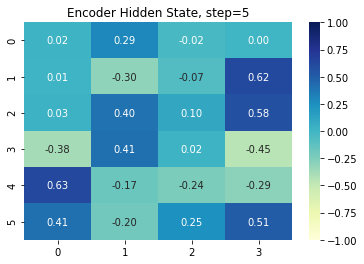

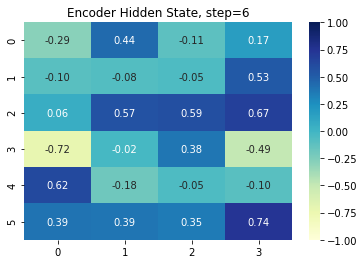

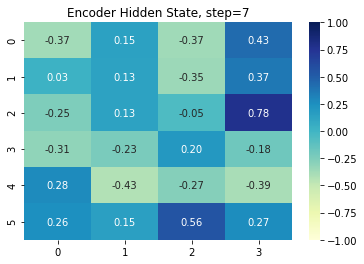

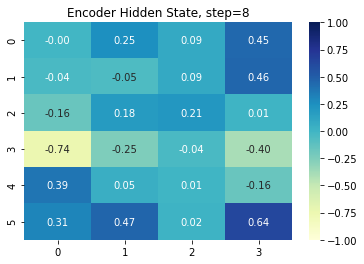

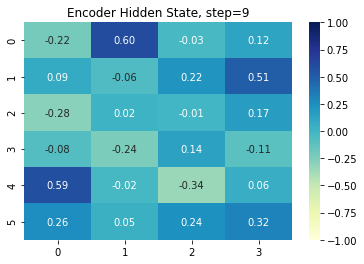

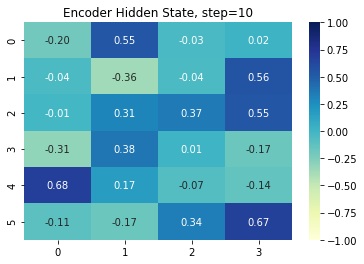

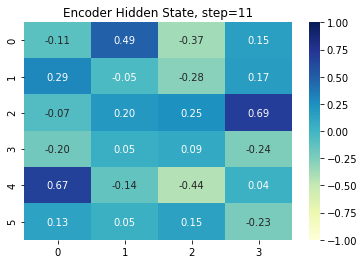

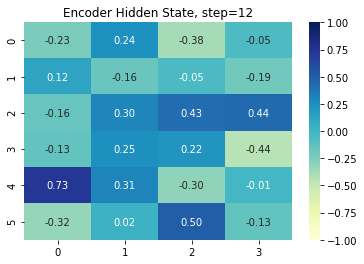

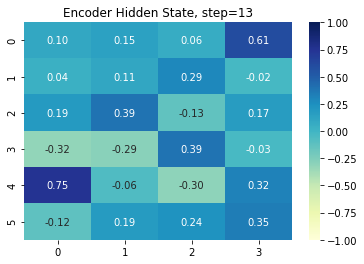

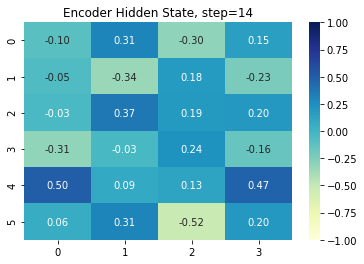

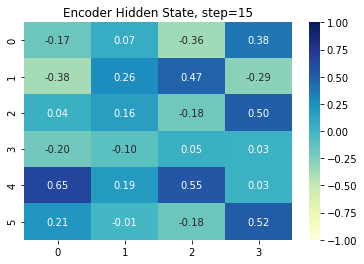

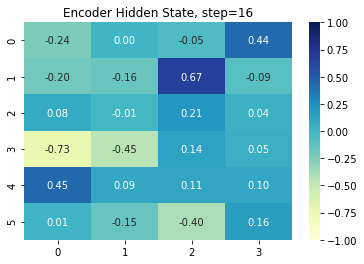

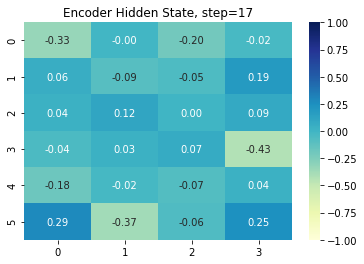

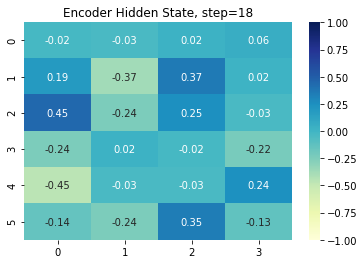

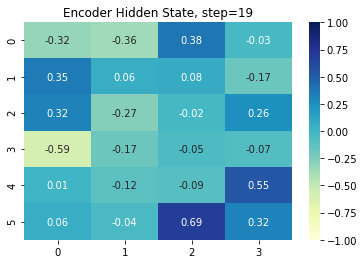

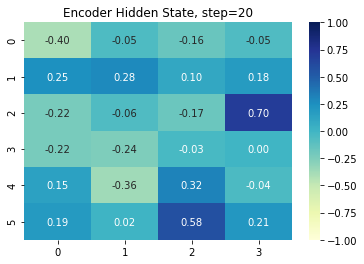

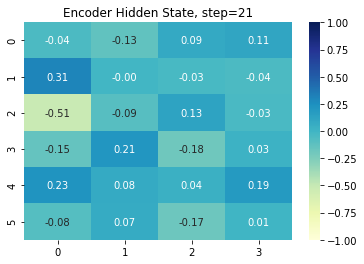

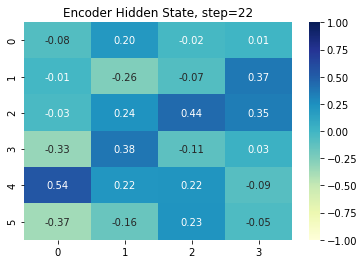

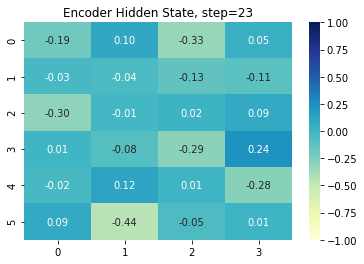

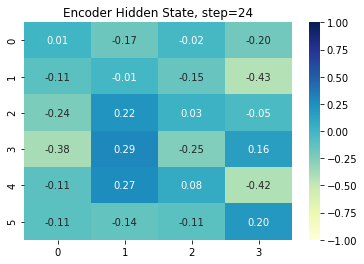

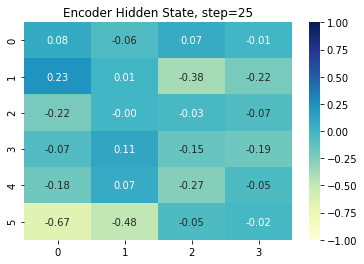

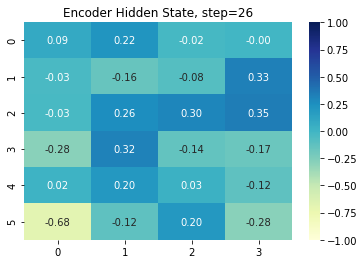

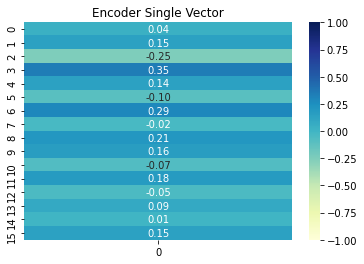

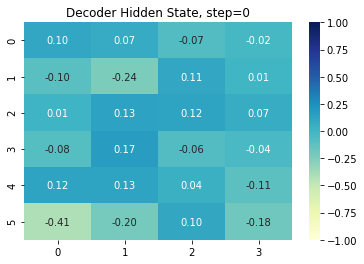

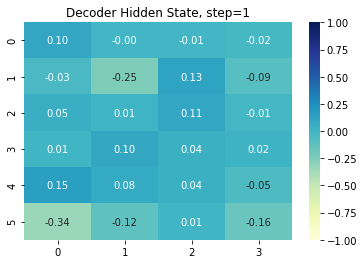

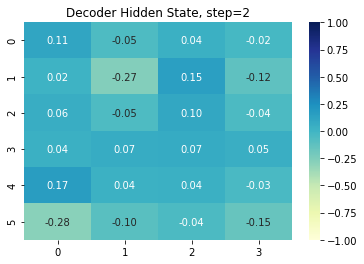

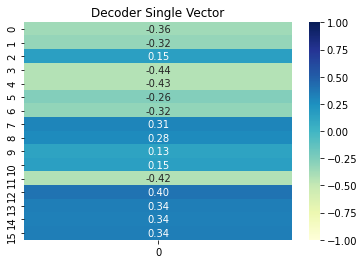

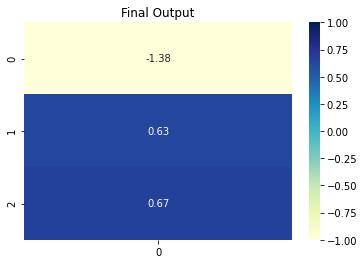

Predicted Label:-  Neutral
Actual Label:-  Negative


In [48]:
print('\n\nInput:-', Incorrect_df.at[0,'tweets_clean'])
print('Predicted Label:- ',classify_tweet(Incorrect_df.at[0,'tweets_clean'], visualize=True))
print('Actual Label:- ' ,categories[Incorrect_df.at[0,'labels']])